In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_tnc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

**Titanic**

In [2]:
Titanic=pd.read_csv("Titanic/tested.csv")

In [3]:
Titanic=Titanic.drop(columns=["PassengerId","Ticket","Name"])

In [4]:
Titanic.loc[pd.isna(Titanic.Cabin)==False,"Cabin"]=1

In [5]:
Titanic.loc[pd.isna(Titanic.Cabin)==True,"Cabin"]=0

In [6]:
Titanic.loc[:,"Sex"]=(Titanic.Sex=="male").astype(int)

In [7]:
Titanic.loc[pd.isna(Titanic.Age)==True,"Age"]=Titanic.Age.median()

In [8]:
Titanic=pd.get_dummies(Titanic,columns=["Embarked"], drop_first = True)

In [9]:
Titanic.loc[:,"Cabin"]=Titanic.loc[:,"Cabin"].astype(int)

In [10]:
Titanic = Titanic[~Titanic.isnull().any(axis = 1)]

In [11]:
Titanic = Titanic.drop(columns = ['Sex'])

**Diabets**

In [12]:
Diabetes=pd.read_csv("diabetes/dataset_37_diabetes.csv")

In [13]:
Diabetes.loc[:,"class"]=(Diabetes["class"]=="tested_positive").astype(int)

**Pokemon**

In [14]:
Pokemon=pd.read_csv("Pokemon/pokemon.csv")

In [15]:
Pokemon=Pokemon.filter(regex='^(?!against).*')

In [16]:
Pokemon=Pokemon.drop(columns=["abilities","classfication","pokedex_number","japanese_name","name"])

In [17]:
Pokemon.loc[pd.isna(Pokemon.height_m),"height_m"]=0

In [18]:
Pokemon.loc[pd.isna(Pokemon.percentage_male),"percentage_male"]=0

In [19]:
Pokemon.loc[pd.isna(Pokemon.weight_kg),"weight_kg"]=0

In [20]:
Pokemon.capture_rate=pd.to_numeric(Pokemon.capture_rate,errors="coerce")

In [21]:
Pokemon.loc[pd.isna(Pokemon.capture_rate),"capture_rate"]=255

In [22]:
types1=pd.get_dummies(Pokemon["type1"],columns=["type1"], drop_first = True)

In [23]:
types2=pd.get_dummies(Pokemon["type2"],columns=["type2"], drop_first = True)

In [24]:
Pokemon=Pokemon.drop(columns=["type1","type2"])

In [25]:
Pokemon=pd.concat([Pokemon,types2+types1], axis=1)

In [26]:
Pokemon=Pokemon[['base_egg_steps', 'base_happiness', 'base_total',
                'percentage_male', 'sp_attack', 'is_legendary']]

**Cancer**

In [27]:
Cancer=pd.read_csv("cancer/wdbc.data",header=None)

In [28]:
Cancer.iloc[:,1]=(Cancer[1]=="M").astype(int)

In [29]:
Cancer=Cancer.drop(columns=[0])

**Bank**

In [30]:
Bank=pd.read_csv("bank/bank.csv",sep=";")

In [31]:
Bank.loc[:,"default"]=(Bank.default=="yes").astype(int)

In [32]:
Bank.loc[:,"housing"]=(Bank.housing=="yes").astype(int)

In [33]:
Bank.loc[:,"loan"]=(Bank.loan=="yes").astype(int)

In [34]:
Bank.loc[:,"y"]=(Bank.y=="yes").astype(int)

In [35]:
Bank=pd.get_dummies(Bank, drop_first = True)

**Model assessement**

In [36]:
def accuracy(Y,Y_hat):
    temp=Y==Y_hat
    return np.mean(temp)

In [37]:
def precision(Y,Y_hat):
    tp=np.logical_and(Y,Y_hat)
    fp=np.logical_and(np.logical_not(Y),Y_hat)
    return np.sum(tp)/(np.sum(tp)+np.sum(fp))

In [38]:
def recall(Y,Y_hat):
    tp=np.logical_and(Y,Y_hat)
    fn=np.logical_and(Y,np.logical_not(Y_hat))
    return np.sum(tp)/(np.sum(tp)+np.sum(fn))

In [39]:
def F_measure(Y,Y_hat):
    pre=precision(Y,Y_hat)
    re=recall(Y,Y_hat)
    return 2*pre*re/(pre+re)

In [40]:
def assess(Y, Y_hat):
    print('Acccuracy: ', accuracy(Y, Y_hat))
    print('Precision: ', precision(Y, Y_hat))
    print('Recall: ', recall(Y, Y_hat))
    print('F_measure: ', F_measure(Y, Y_hat))
    print('R2_score: ', r2_score(Y, Y_hat))

**Auxiliary Gradient Descent Functions**

In [41]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

def MSE_grad(Y,Y_hat):
     return Y_hat-Y

def sigmoid(x):
    return(1/(1 + np.exp(np.clip(-x,-100,100))))

def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

def cross_entropy(Y, Y_hat,  epsilon=1e-10):
    Y_hat = np.clip(Y_hat, epsilon, 1-epsilon)
    return np.sum(np.log(Y_hat) * Y + np.log((1 - Y_hat)) * (1 - Y))

def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [42]:
class LogisticRegression:
    
    def __init__(self, solver: str, intercept: bool = True, iterations: int = 1000, 
                 alpha: int = None, batch_size: int = None, eps: float = 10**-8,
                 normalize: bool = False, tol: float = 0.0001):
        
        
        self.solver = solver
        self.intercept = intercept
        self.iterations = iterations
        self.batch_size = batch_size
        self.alpha = alpha
        self.normalize = normalize
        self.tolerance = tol
        self.epsilon = eps
        
    def fit(self, X, Y, verbose = False, save_errors = False):

        if self.normalize:
            self.std = X.std(0)
            self.mean = X.mean(0)
            X = (X-self.mean)/self.std
            
        if self.intercept:
            X = np.insert(X, 0, values=1, axis=1)
            
        self.Beta=np.zeros(X.shape[1])
        
        if self.solver == 'gd':
            self._gradient_descent(X, Y, X.shape[0], verbose, save_errors)
        elif self.solver == 'sgd':
            self._gradient_descent(X, Y, self.batch_size, verbose, save_errors)
        elif self.solver == 'powell':
            self._powell(X, Y)
        else:
            self._iwls(X, Y, verbose, save_errors)
    
    def _gradient_descent(self, X, Y, batch_size, verbose, save_errors):
        
        batches = np.linspace(0,X.shape[0],int(X.shape[0]/batch_size)+1).astype(int)
        
        if save_errors:
            self.errors = [cross_entropy(Y, sigmoid(X @ self.Beta))]
        
        for epoch in range(self.iterations):
            s = np.arange(0, X.shape[0], 1)
            np.random.shuffle(s)
            
            X = X[s,:]
            Y = Y[s]
            
            for b in range(len(batches)-1):
                X_b=X[batches[b]:batches[b+1],:]
                Y_b=Y[batches[b]:batches[b+1]]
                
                pred=sigmoid(X_b @ self.Beta)
                error=cross_entropy(Y_b,pred)
                
                delta = self.alpha * (X_b*(cross_entropy_grad(Y_b,pred) * sigmoid_grad(X_b @ self.Beta)).reshape(-1,1)).mean(axis=0)
                if abs(delta.max()) < self.tolerance:
                    return

                self.Beta = self.Beta - delta
                
            pred=sigmoid(X @ self.Beta)
            error=cross_entropy(Y,pred)
            
            if save_errors:
                self.errors.append(error)
            
            if verbose: 
                print('Iteration no.', epoch+1, ':', error)
                
    
    def _iwls(self, X, Y, verbose, save_errors):
        
        W = np.ones(X.shape[0])*0.5
        X1 = X[:,1:] if self.intercept else X
        
        if save_errors:
            self.errors = [cross_entropy(Y, sigmoid(X @ self.Beta))]
        
        for i in range(self.iterations):
            
            delta = np.linalg.inv((X.T * W[:,None].T) @ X) @ X.T @ (Y-self.predict(X1, _internal_pass = True))
            if abs(delta.max()) < self.tolerance:
                return
            
            self.Beta += delta

            W = (1-self.predict(X1, _internal_pass = True)) * self.predict(X1, _internal_pass = True) + self.epsilon
            
            pred = sigmoid(X @ self.Beta)
            error = cross_entropy(Y, pred)
            
            if save_errors:
                self.errors.append(error)
            
            if verbose: 
                print('Iteration no.', i+1, ':', error)

    def _powell(self, X, Y):
        self.Beta = minimize(fun = lambda x: -cross_entropy(Y, sigmoid(X @ x)), x0 = self.Beta, 
                             method = 'Powell',options={'xtol': self.tolerance, 'maxiter': self.iterations}).x
    
    def predict(self, X, rounding = False, _internal_pass = False):
        
        if (not _internal_pass) and self.normalize:
            X = (X-self.mean)/self.std
            
        if self.intercept:
            X = np.insert(X, 0, values=1, axis=1)
            
        ret = np.exp(np.clip(X @ self.Beta, -100, 100))/(1+np.exp(np.clip(X @ self.Beta, -100, 100)))
        
        if rounding:
            ret = ret.round()

        return ret
    

**Cancer**

In [43]:
np.random.seed(111)
Y = Cancer[1].to_numpy()
X = Cancer.loc[:,2:].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [44]:
mod_sgd = LogisticRegression('sgd', alpha = 0.1, batch_size = 100, normalize = True)
mod_sgd.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

Iteration no. 1 : -158.88853543873998
Iteration no. 2 : -122.54836267002526
Iteration no. 3 : -104.79193869519422
Iteration no. 4 : -93.67644596285164
Iteration no. 5 : -85.90976234839403
Iteration no. 6 : -80.08481651554258
Iteration no. 7 : -75.51958904525705
Iteration no. 8 : -71.82854021656377
Iteration no. 9 : -68.76492051604058
Iteration no. 10 : -66.17791351147598
Iteration no. 11 : -63.957563323457165
Iteration no. 12 : -62.025690029425036
Iteration no. 13 : -60.32466785811319
Iteration no. 14 : -58.81309073005618
Iteration no. 15 : -57.46085282318394
Iteration no. 16 : -56.239009970225396
Iteration no. 17 : -55.130403575841626
Iteration no. 18 : -54.11913544449864
Iteration no. 19 : -53.19089326194663
Iteration no. 20 : -52.33531202889323
Iteration no. 21 : -51.54382643547268
Iteration no. 22 : -50.80868885532784
Iteration no. 23 : -50.123008388711874
Iteration no. 24 : -49.482976662357835
Iteration no. 25 : -48.882784359175496
Iteration no. 26 : -48.31781844764684
Iteration n

In [45]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.9824561403508771
Precision:  0.9772727272727273
Recall:  0.9772727272727273
F_measure:  0.9772727272727273
R2_score:  0.925974025974026


In [46]:
mod_gd = LogisticRegression('gd', alpha = 0.1, normalize = True)
mod_gd.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

Iteration no. 1 : -238.39442025702206
Iteration no. 2 : -199.18382755670152
Iteration no. 3 : -175.15119005756748
Iteration no. 4 : -158.58534542023475
Iteration no. 5 : -146.30025239474062
Iteration no. 6 : -136.7273345412594
Iteration no. 7 : -128.99689483808535
Iteration no. 8 : -122.58426869926275
Iteration no. 9 : -117.15231184289806
Iteration no. 10 : -112.47346058728111
Iteration no. 11 : -108.38793270588329
Iteration no. 12 : -104.77984191943087
Iteration no. 13 : -101.56282830820658
Iteration no. 14 : -98.67103678245003
Iteration no. 15 : -96.05324545738671
Iteration no. 16 : -93.6689243421358
Iteration no. 17 : -91.48551795602972
Iteration no. 18 : -89.47652731507092
Iteration no. 19 : -87.62012776469848
Iteration no. 20 : -85.89815438732809
Iteration no. 21 : -84.29534479927878
Iteration no. 22 : -82.79876554582755
Iteration no. 23 : -81.39737166563633
Iteration no. 24 : -80.08166432418673
Iteration no. 25 : -78.84342167415966
Iteration no. 26 : -77.67548509092961
Iteration 

Iteration no. 238 : -38.79962726833438
Iteration no. 239 : -38.76085291249302
Iteration no. 240 : -38.722318510493004
Iteration no. 241 : -38.68402151727255
Iteration no. 242 : -38.645959425537086
Iteration no. 243 : -38.60812976504535
Iteration no. 244 : -38.570530101911814
Iteration no. 245 : -38.533158037924935
Iteration no. 246 : -38.49601120988109
Iteration no. 247 : -38.459087288933304
Iteration no. 248 : -38.42238397995486
Iteration no. 249 : -38.385899020917066
Iteration no. 250 : -38.34963018228096
Iteration no. 251 : -38.31357526640254
Iteration no. 252 : -38.277732106951234
Iteration no. 253 : -38.2420985683411
Iteration no. 254 : -38.20667254517463
Iteration no. 255 : -38.1714519616987
Iteration no. 256 : -38.13643477127242
Iteration no. 257 : -38.10161895584652
Iteration no. 258 : -38.06700252545396
Iteration no. 259 : -38.03258351771171
Iteration no. 260 : -37.998359997333026
Iteration no. 261 : -37.96433005565028
Iteration no. 262 : -37.93049181014798
Iteration no. 263 :

Iteration no. 453 : -33.64719666715395
Iteration no. 454 : -33.63194946207142
Iteration no. 455 : -33.61675007641725
Iteration no. 456 : -33.60159825134498
Iteration no. 457 : -33.5864937300051
Iteration no. 458 : -33.571436257524994
Iteration no. 459 : -33.55642558098919
Iteration no. 460 : -33.541461449419856
Iteration no. 461 : -33.52654361375748
Iteration no. 462 : -33.51167182684181
Iteration no. 463 : -33.49684584339296
Iteration no. 464 : -33.48206541999267
Iteration no. 465 : -33.46733031506565
Iteration no. 466 : -33.45264028886053
Iteration no. 467 : -33.437995103428946
Iteration no. 468 : -33.42339452259079
Iteration no. 469 : -33.40883831065724
Iteration no. 470 : -33.394326237923174
Iteration no. 471 : -33.37985807188453
Iteration no. 472 : -33.36543358341519
Iteration no. 473 : -33.35105254506454
Iteration no. 474 : -33.33671473106449
Iteration no. 475 : -33.32241991731687
Iteration no. 476 : -33.308167881378424
Iteration no. 477 : -33.293958402445206
Iteration no. 478 : 

Iteration no. 702 : -30.878940525536652
Iteration no. 703 : -30.870737153211884
Iteration no. 704 : -30.862550193786934
Iteration no. 705 : -30.85437959051343
Iteration no. 706 : -30.84622528691853
Iteration no. 707 : -30.8380872268031
Iteration no. 708 : -30.829965354240073
Iteration no. 709 : -30.82185961357267
Iteration no. 710 : -30.81376994941273
Iteration no. 711 : -30.80569630663897
Iteration no. 712 : -30.797638630395376
Iteration no. 713 : -30.789596866089482
Iteration no. 714 : -30.781570959390756
Iteration no. 715 : -30.773560856228933
Iteration no. 716 : -30.76556650279239
Iteration no. 717 : -30.757587845526583
Iteration no. 718 : -30.749624831132355
Iteration no. 719 : -30.741677406564428
Iteration no. 720 : -30.733745519029785
Iteration no. 721 : -30.72582911598613
Iteration no. 722 : -30.717928145140306
Iteration no. 723 : -30.710042554446776
Iteration no. 724 : -30.70217229210609
Iteration no. 725 : -30.69431730656337
Iteration no. 726 : -30.6864775465068
Iteration no.

Iteration no. 913 : -29.441607950145436
Iteration no. 914 : -29.435930027415914
Iteration no. 915 : -29.43026074371075
Iteration no. 916 : -29.42460007583647
Iteration no. 917 : -29.41894800068576
Iteration no. 918 : -29.41330449523697
Iteration no. 919 : -29.407669536553833
Iteration no. 920 : -29.402043101784955
Iteration no. 921 : -29.39642516816344
Iteration no. 922 : -29.39081571300649
Iteration no. 923 : -29.38521471371502
Iteration no. 924 : -29.37962214777322
Iteration no. 925 : -29.3740379927482
Iteration no. 926 : -29.368462226289573
Iteration no. 927 : -29.36289482612907
Iteration no. 928 : -29.35733577008015
Iteration no. 929 : -29.35178503603761
Iteration no. 930 : -29.34624260197721
Iteration no. 931 : -29.340708445955276
Iteration no. 932 : -29.335182546108328
Iteration no. 933 : -29.329664880652714
Iteration no. 934 : -29.324155427884214
Iteration no. 935 : -29.31865416617769
Iteration no. 936 : -29.313161073986663
Iteration no. 937 : -29.30767612984302
Iteration no. 93

In [47]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.9736842105263158
Precision:  0.9767441860465116
Recall:  0.9545454545454546
F_measure:  0.9655172413793104
R2_score:  0.888961038961039


In [48]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-6)
mod_iwls.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

Iteration no. 1 : -179.03412927319164
Iteration no. 2 : -87.78824330378977
Iteration no. 3 : -52.68282093631067
Iteration no. 4 : -34.92479402511751
Iteration no. 5 : -24.841742001000753
Iteration no. 6 : -17.401738579894023
Iteration no. 7 : -10.731459574519699
Iteration no. 8 : -6.137317083706254
Iteration no. 9 : -2.907393725260256
Iteration no. 10 : -1.2321894049347124
Iteration no. 11 : -0.5280352783849247
Iteration no. 12 : -0.257456551948247
Iteration no. 13 : -0.14794630370483833
Iteration no. 14 : -0.09768520655413018
Iteration no. 15 : -0.07106526422907611
Iteration no. 16 : -0.05517797243718031
Iteration no. 17 : -0.04481179647399784
Iteration no. 18 : -0.037587495488266336
Iteration no. 19 : -0.03229635263581217
Iteration no. 20 : -0.028269305642632744
Iteration no. 21 : -0.025109728270167567
Iteration no. 22 : -0.022569094930568214
Iteration no. 23 : -0.02048443817999531
Iteration no. 24 : -0.018744778405574775
Iteration no. 25 : -0.017272094967554538
Iteration no. 26 : -0

Iteration no. 245 : -0.0009130044908941735
Iteration no. 246 : -0.0009090737919826965
Iteration no. 247 : -0.0009051767621190993
Iteration no. 248 : -0.0009013129708322323
Iteration no. 249 : -0.0008974819949604706
Iteration no. 250 : -0.0008936834184862678
Iteration no. 251 : -0.0008899168323935812
Iteration no. 252 : -0.0008861818345170804
Iteration no. 253 : -0.0008824780294025716
Iteration no. 254 : -0.0008788050281650899
Iteration no. 255 : -0.0008751624483554303
Iteration no. 256 : -0.0008715499138246812
Iteration no. 257 : -0.0008679670545981944
Iteration no. 258 : -0.0008644135067476693
Iteration no. 259 : -0.0008608889122690102
Iteration no. 260 : -0.0008573929189590742
Iteration no. 261 : -0.000853925180306297
Iteration no. 262 : -0.0008504853553665538
Iteration no. 263 : -0.0008470731086611131
Iteration no. 264 : -0.000843688110057606
Iteration no. 265 : -0.0008403300346770845
Iteration no. 266 : -0.0008369985627756576
Iteration no. 267 : -0.0008336933796529945
Iteration no.

Iteration no. 443 : -0.0004917759324232149
Iteration no. 444 : -0.000490632338600355
Iteration no. 445 : -0.0004894940489205354
Iteration no. 446 : -0.0004883610265782846
Iteration no. 447 : -0.00048723323510976933
Iteration no. 448 : -0.0004861106383884657
Iteration no. 449 : -0.00048499320061616514
Iteration no. 450 : -0.0004838808863238625
Iteration no. 451 : -0.0004827736603678702
Iteration no. 452 : -0.00048167148792459957
Iteration no. 453 : -0.00048057433448745227
Iteration no. 454 : -0.00047948216586293384
Iteration no. 455 : -0.0004783949481674338
Iteration no. 456 : -0.00047731264782411735
Iteration no. 457 : -0.00047623523155770615
Iteration no. 458 : -0.00047516266639370145
Iteration no. 459 : -0.0004740949196541649
Iteration no. 460 : -0.00047303195895216703
Iteration no. 461 : -0.00047197375219156505
Iteration no. 462 : -0.0004709202675618957
Iteration no. 463 : -0.000469871473536154
Iteration no. 464 : -0.0004688273388676851
Iteration no. 465 : -0.00046778783258529877
It

Iteration no. 633 : -0.0003408193482676207
Iteration no. 634 : -0.00034026955861929484
Iteration no. 635 : -0.00033972153950373126
Iteration no. 636 : -0.00033917528238554284
Iteration no. 637 : -0.0003386307787798603
Iteration no. 638 : -0.00033808802026099184
Iteration no. 639 : -0.0003375469984535412
Iteration no. 640 : -0.00033700770503829213
Iteration no. 641 : -0.0003364701317473232
Iteration no. 642 : -0.00033593427036567275
Iteration no. 643 : -0.00033540011273167276
Iteration no. 644 : -0.0003348676507336174
Iteration no. 645 : -0.0003343368763136492
Iteration no. 646 : -0.0003338077814615415
Iteration no. 647 : -0.00033328035822124914
Iteration no. 648 : -0.0003327545986842465
Iteration no. 649 : -0.00033223049499385817
Iteration no. 650 : -0.0003317080393402619
Iteration no. 651 : -0.0003311872239650416
Iteration no. 652 : -0.0003306680411567455
Iteration no. 653 : -0.0003301504832534401
Iteration no. 654 : -0.00032963454264048976
Iteration no. 655 : -0.0003291202117507784
I

Iteration no. 823 : -0.0002607632100276176
Iteration no. 824 : -0.00026044122065139725
Iteration no. 825 : -0.00026012002540201645
Iteration no. 826 : -0.00025979962134551406
Iteration no. 827 : -0.00025948000556302864
Iteration no. 828 : -0.00025916117514835594
Iteration no. 829 : -0.0002588431272129446
Iteration no. 830 : -0.00025852585887845784
Iteration no. 831 : -0.0002582093672829907
Iteration no. 832 : -0.0002578936495781836
Iteration no. 833 : -0.0002575787029299991
Iteration no. 834 : -0.0002572645245163908
Iteration no. 835 : -0.00025695111153218827
Iteration no. 836 : -0.00025663846118199136
Iteration no. 837 : -0.00025632657068871923
Iteration no. 838 : -0.0002560154372830629
Iteration no. 839 : -0.0002557050582145879
Iteration no. 840 : -0.000255395430742408
Iteration no. 841 : -0.0002550865521417357
Iteration no. 842 : -0.00025477841969744297
Iteration no. 843 : -0.00025447103071138866
Iteration no. 844 : -0.00025416438249520194
Iteration no. 845 : -0.00025385847237550057

In [49]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.9298245614035088
Precision:  0.9090909090909091
Recall:  0.9090909090909091
F_measure:  0.9090909090909091
R2_score:  0.7038961038961039


In [50]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [51]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.9298245614035088
Precision:  0.9090909090909091
Recall:  0.9090909090909091
F_measure:  0.9090909090909091
R2_score:  0.7038961038961039


In [52]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [53]:
assess(Y_test, Y_hat)

Acccuracy:  0.9649122807017544
Precision:  0.9761904761904762
Recall:  0.9318181818181818
F_measure:  0.9534883720930233
R2_score:  0.851948051948052


In [54]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [55]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.956140350877193
Precision:  1.0
Recall:  0.8863636363636364
F_measure:  0.9397590361445783
R2_score:  0.814935064935065


In [56]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [57]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.9736842105263158
Precision:  0.9361702127659575
Recall:  1.0
F_measure:  0.967032967032967
R2_score:  0.888961038961039


In [58]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [59]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.9824561403508771
Precision:  0.9772727272727273
Recall:  0.9772727272727273
F_measure:  0.9772727272727273
R2_score:  0.925974025974026


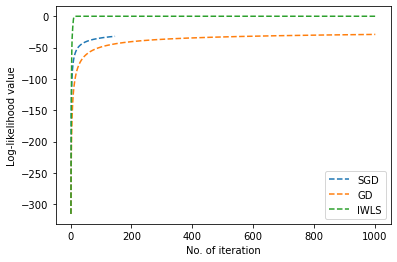

In [60]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [61]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

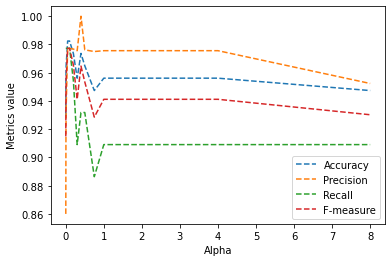

In [62]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [63]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

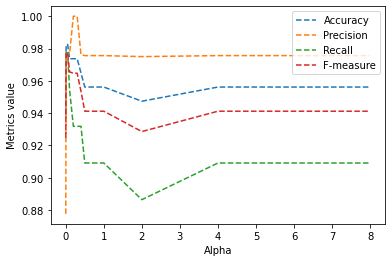

In [64]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

**Bank**

In [65]:
np.random.seed(111)
Y = Bank['y'].to_numpy()
X = Bank.drop(columns=['y']).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [66]:
mod_sgd = LogisticRegression('sgd', alpha = 0.5, batch_size = 1000, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [67]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [68]:
mod_gd = LogisticRegression('gd', alpha = 0.5, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [69]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [70]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-8)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [71]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [72]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [73]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [74]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [75]:
assess(Y_test, Y_hat)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [76]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [77]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.8983425414364641
Precision:  0.6142857142857143
Recall:  0.39814814814814814
F_measure:  0.48314606741573035
R2_score:  0.032715274873367894


In [78]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [79]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.8519337016574585
Precision:  0.3984375
Recall:  0.4722222222222222
F_measure:  0.43220338983050843
R2_score:  -0.4088712300757469


In [80]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [81]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.8883977900552487
Precision:  0.5945945945945946
Recall:  0.2037037037037037
F_measure:  0.30344827586206896
R2_score:  -0.061910404758585225


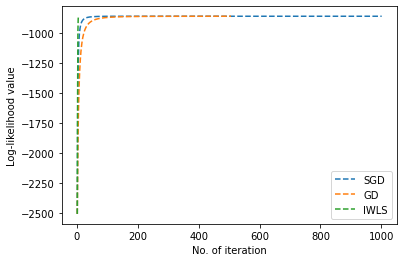

In [82]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [83]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

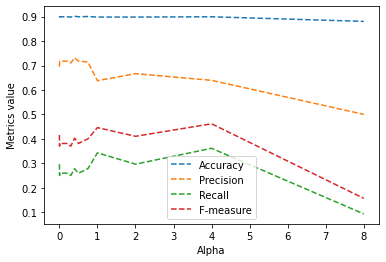

In [84]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [85]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

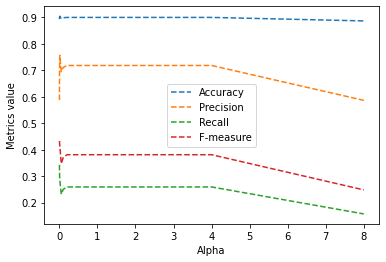

In [86]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

**Pokemon**

In [87]:
np.random.seed(111)
Y = Pokemon["is_legendary"].to_numpy()
X = Pokemon.drop(columns=["is_legendary"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [88]:
mod_sgd = LogisticRegression('sgd', alpha = 0.01, batch_size = 200, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [89]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [90]:
mod_gd = LogisticRegression('gd', alpha = 0.01, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [91]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [92]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-6)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [93]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.9627329192546584
Precision:  0.7142857142857143
Recall:  0.8333333333333334
F_measure:  0.7692307692307692
R2_score:  0.45973154362416113


In [94]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [95]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.9627329192546584
Precision:  0.7142857142857143
Recall:  0.8333333333333334
F_measure:  0.7692307692307692
R2_score:  0.45973154362416113


In [96]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [97]:
assess(Y_test, Y_hat)

Acccuracy:  0.9751552795031055
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F_measure:  0.8333333333333334
R2_score:  0.639821029082774


In [98]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [99]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [100]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [101]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.9565217391304348
Precision:  0.6666666666666666
Recall:  0.8333333333333334
F_measure:  0.7407407407407408
R2_score:  0.3696868008948546


In [102]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [103]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.9751552795031055
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F_measure:  0.8333333333333334
R2_score:  0.639821029082774


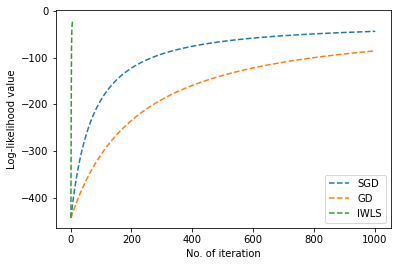

In [104]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [105]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

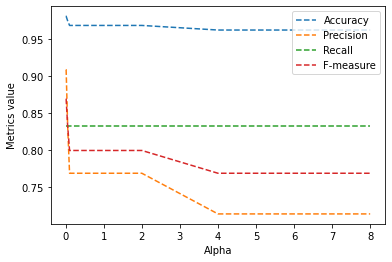

In [106]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [107]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

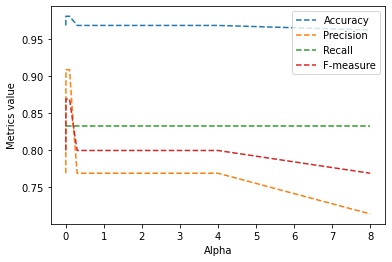

In [108]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

**Diabetes**

In [109]:
np.random.seed(111)
Y = Diabetes["class"].to_numpy()
X = Diabetes.drop(columns=["class"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [110]:
mod_sgd = LogisticRegression('sgd', alpha = 0.5, batch_size = 200, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [111]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [112]:
mod_gd = LogisticRegression('gd',alpha = 0.01, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [113]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.7272727272727273
Precision:  0.6222222222222222
Recall:  0.5283018867924528
F_measure:  0.5714285714285715
R2_score:  -0.20829441434709484


In [114]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-5)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [115]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [116]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [117]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [118]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [119]:
assess(Y_test, Y_hat)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [120]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [121]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.7467532467532467
Precision:  0.6666666666666666
Recall:  0.5283018867924528
F_measure:  0.5894736842105263
R2_score:  -0.12198767046515946


In [122]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [123]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.7337662337662337
Precision:  0.6153846153846154
Recall:  0.6037735849056604
F_measure:  0.6095238095238096
R2_score:  -0.17952549971978304


In [124]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [125]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.6818181818181818
Precision:  0.5384615384615384
Recall:  0.5283018867924528
F_measure:  0.5333333333333333
R2_score:  -0.40967681673827716


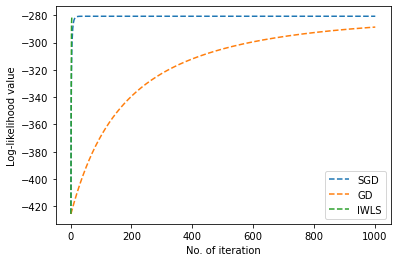

In [126]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [127]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

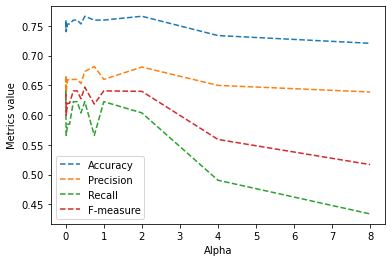

In [128]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [129]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

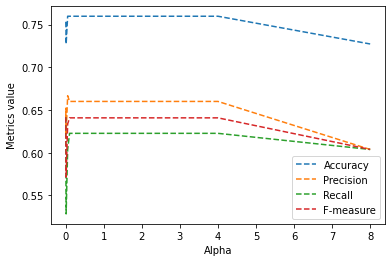

In [130]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

**Titanic**

In [131]:
np.random.seed(111)
Y = Titanic["Survived"].to_numpy()
X = Titanic.drop(columns=["Survived"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [132]:
mod_sgd = LogisticRegression('sgd', alpha = 0.1, batch_size = 100, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [133]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.5238095238095238
Precision:  0.6
Recall:  0.07317073170731707
F_measure:  0.13043478260869565
R2_score:  -0.9058423142370962


In [134]:
mod_gd = LogisticRegression('gd', alpha = 0.1, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [135]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [136]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-5)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [137]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [138]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [139]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [140]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [141]:
assess(Y_test, Y_hat)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [142]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [143]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [144]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [145]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.5833333333333334
Precision:  0.6363636363636364
Recall:  0.34146341463414637
F_measure:  0.4444444444444445
R2_score:  -0.6676120249574593


In [146]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [147]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.6071428571428571
Precision:  0.6666666666666666
Recall:  0.3902439024390244
F_measure:  0.4923076923076923
R2_score:  -0.5723199092456044


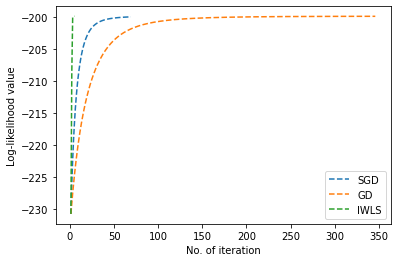

In [148]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Log-likelihood value')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.show()

In [149]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

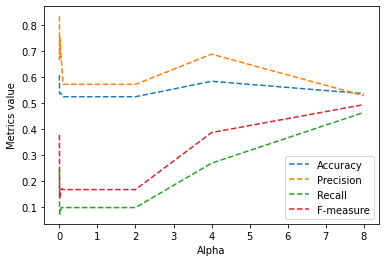

In [150]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()

In [151]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

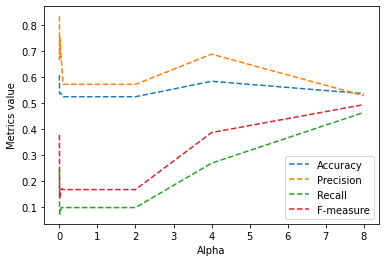

In [152]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.show()